In [5]:
import os
import random
from PIL import Image
from tabulate import tabulate

# Reading the database

You can download the database here:

- [https://dna.hamilton.ie/tsterin/all_5_states_undecided_machines_with_global_header.zip](https://dna.hamilton.ie/tsterin/all_5_states_undecided_machines_with_global_header.zip)
- [ipfs://QmPRjcK9mJz4UMwkzLNrVG3YtAUzdRHACuHbmpf1n1bfYr](ipfs://QmPRjcK9mJz4UMwkzLNrVG3YtAUzdRHACuHbmpf1n1bfYr)
- [https://ipfs.prgm.dev/ipfs/QmPRjcK9mJz4UMwkzLNrVG3YtAUzdRHACuHbmpf1n1bfYr](https://ipfs.prgm.dev/ipfs/QmPRjcK9mJz4UMwkzLNrVG3YtAUzdRHACuHbmpf1n1bfYr)

In [6]:
DB_PATH = "all_5_states_undecided_machines_with_global_header"

## Database header
The first 30 bytes of the database are reserved for a header which currently contains **three** 4-byte int: 
1. The number of machines that are undecided because they went beyond the time limit (`47,176,870` steps)
2. The number of machines that are undecided because they went beyond the space limit (`12,289` memory cells)
3. The total number of undecided machines (sum of above)

In [7]:
def get_header(machine_db_path):
    with open(machine_db_path, "rb") as f:
        return f.read(30)

In [8]:
header = get_header(DB_PATH)
undecided_time, undecided_space, undecided_total = int.from_bytes(header[:4],byteorder='big'),int.from_bytes(header[4:8],byteorder='big'),int.from_bytes(header[8:12],byteorder='big')
print(undecided_time, undecided_space, undecided_total)

14322029 74342035 88664064


## Database core

The core of the database is `88,664,064` machines descriptions which are each written on 30 bytes.

In [9]:
n = os.path.getsize(DB_PATH)
print((n)/30-1)

88664064.0


In [10]:
def get_machine_i(machine_db_path, i, db_has_header=False):
    with open(machine_db_path, "rb") as f:
        c = 1 if db_has_header else 0
        f.seek(30*(i+c))
        return f.read(30)

In [11]:
def ithl(i):
    return chr(ord("A")+i)

def g(move):
    if move == 0:
        return "R"
    return "L"

def pptm(machine):
    headers = ["s","0","1"]
    table = []
    
    for i in range(5):
        row = [ithl(i)]
        for j in range(2):
            write = machine[6*i+3*j] 
            move = machine[6*i+3*j+1] 
            goto = machine[6*i+3*j+2]-1
            
            if goto == -1:
                row.append("???")
                continue
                
            row.append(f"{write}{g(move)}{ithl(goto)}")
        table.append(row)
    
    print(tabulate(table,headers=headers))

In [12]:
pptm(get_machine_i(DB_PATH,3930290,db_has_header=True))

s    0    1
---  ---  ---
A    1RB  1LB
B    0RC  1RE
C    0LD  1RA
D    0LA  ???
E    ???  0RC


# Simulating and visualising machines

In [13]:
def step(machine, curr_state, curr_pos, tape):
    if not curr_pos in tape:
        tape[curr_pos] = 0
    
    write = machine[curr_state*6 + 3*tape[curr_pos]] 
    move = machine[curr_state*6 + 3*tape[curr_pos] + 1] 
    goto = machine[curr_state*6 + 3*tape[curr_pos] + 2] - 1

    if goto == -1:
        return None, None
    
    tape[curr_pos] = write
    next_pos = curr_pos  + (-1 if move else 1)
    return goto, next_pos

In [14]:
def simulate(machine, time_limit = 1000, mini =-10, maxi=-10):
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    
    while curr_state != None and curr_time < time_limit:
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        if curr_state is not None:
            pprinttape(tape, curr_state, curr_pos, mini=mini, maxi=maxi)
        else:
            print("HALT")
        curr_time += 1
        

In [70]:
def tm_trace_to_image(machine, width=900, height=1000, origin=0.5, show_head_direction=False):
    img = Image.new('RGB', (width, height), color = 'black')
    pixels = img.load()
    
    
    tape = {}
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    
    
    for row in range(1,height):
        last_pos = curr_pos
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        
        if curr_state is None: #halt
            return img
        
        for col in range(width):
            pos = col-width*(origin)
            
            if pos in tape:
                pixels[col,row] = (255,255,255) if tape[pos] == 1 else (0,0,0)
                #pixels[col,row-1] = colors[curr_state-1]
                
            if pos == curr_pos and show_head_direction:
                pixels[col,row] = (255,0,0) if curr_pos > last_pos else (0,255,0) 
                
                
    #img = zoom_at(img,*zoom)
    return img

In [16]:
def zoom_at(img, x, y, zoom):
    w, h = img.size
    zoom2 = zoom * 2
    img = img.crop((x - w / zoom2, y - h / zoom2, 
                    x + w / zoom2, y + h / zoom2))
    return img.resize((w, h), Image.LANCZOS)

## BB(5) champion

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [17]:
def repr_to_bytes(rep):
    to_rep = bytearray()
    for a in rep:
        to_rep.append(a)
    return to_rep

R, L = 0, 1
bb5_champion_repr = [1, R, 2, 1, L, 3,
		1, R, 3, 1, R, 2,
		1, R, 4, 0, L, 5,
		1, L, 1, 1, L, 4,
		1, R, 6, 0, L, 1]
bb5_champion = repr_to_bytes(bb5_champion_repr)
pptm(bb5_champion)

s    0    1
---  ---  ---
A    1RB  1LC
B    1RC  1RB
C    1RD  0LE
D    1LA  1LD
E    1RF  0LA


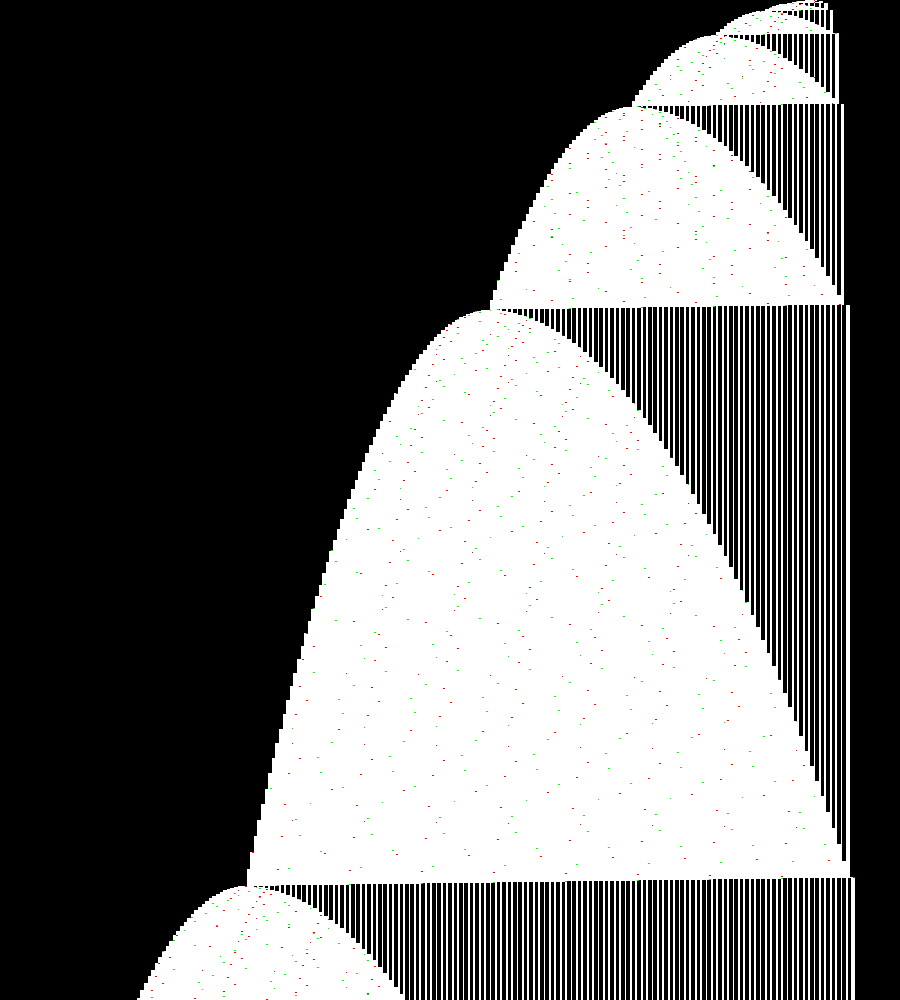

In [102]:
img = tm_trace_to_image(bb5_champion, origin=0.9, width=500, height=40000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Other Halting machines

These were find while running [https://github.com/bbchallenge/bbchallenge-seed](https://github.com/bbchallenge/bbchallenge-seed).

### 40899 steps

In [64]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 0, L, C,
		0, R, C, 0, 0, 0,
		1, R, D, 0, R, E,
		1, L, E, 0, R, A,
		0, L, A, 0, L, E]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 40899 steps.")

s    0    1
---  ---  ---
A    1RB  0LC
B    0RC  ???
C    1RD  0RE
D    1LE  0RA
E    0LA  0LE
Halts after 40899 steps


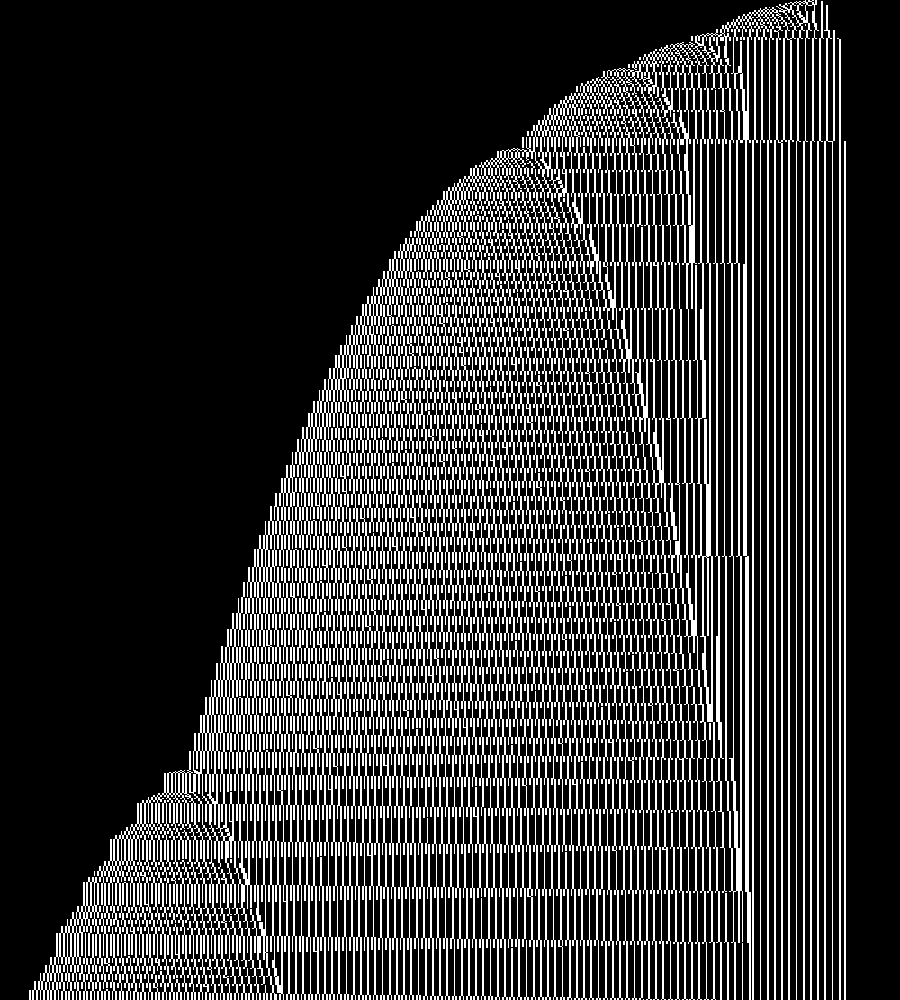

In [79]:
img = tm_trace_to_image(m, origin=0.9, width=500, height=40899).resize((900,1000), Image.NEAREST)
img

### 20739 Steps

In [85]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 0, L, A,
		0, R, C, 1, R, D,
		1, L, C, 1, L, A,
		1, R, A, 1, R, E,
		0, 0, 0, 0, R, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 20739 steps.")

s    0    1
---  ---  ---
A    1RB  0LA
B    0RC  1RD
C    1LC  1LA
D    1RA  1RE
E    ???  0RB
Halts after 20739 steps.


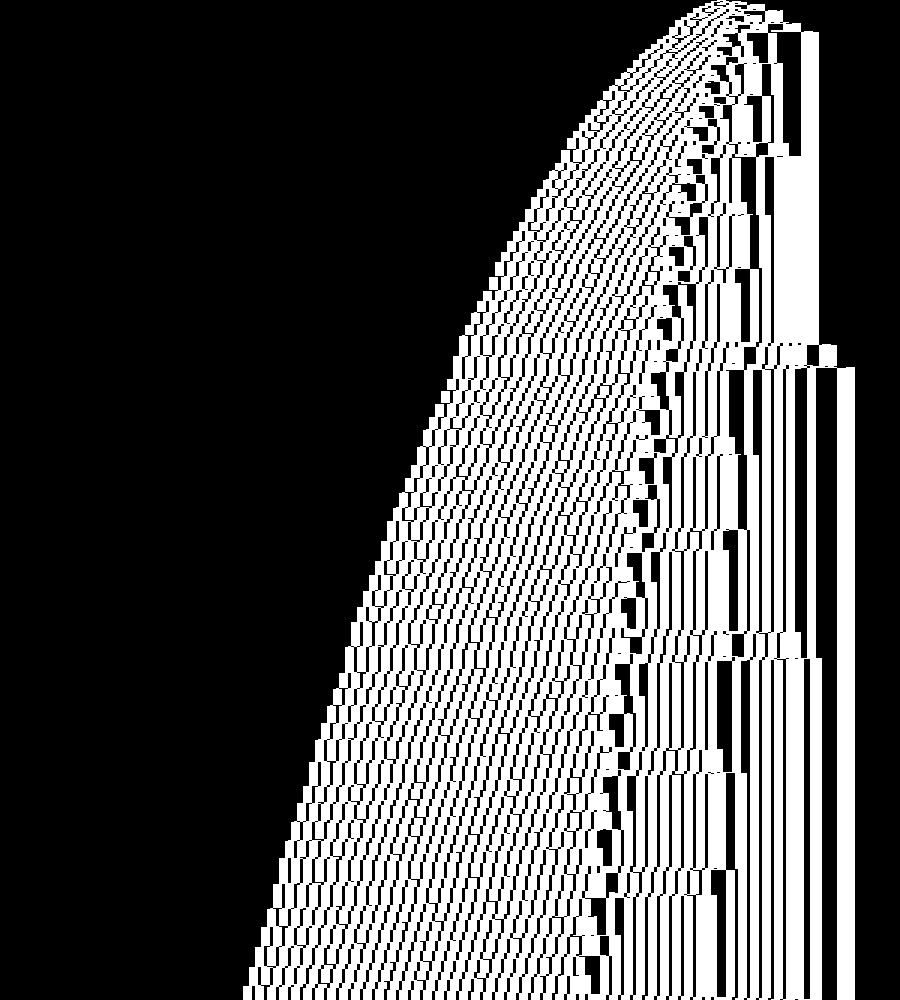

In [87]:
img = tm_trace_to_image(m, origin=0.8, width=300, height=20739).resize((900,1000), Image.NEAREST)
img

### 5309 Steps

In [89]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, D,
		0, R, C, 1, L, E,
		1, L, B, 1, R, D,
		1, R, C, 0, L, A,
		0, 0, 0, 1, L, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 5309 steps.")

s    0    1
---  ---  ---
A    1RB  1LD
B    0RC  1LE
C    1LB  1RD
D    1RC  0LA
E    ???  1LB
Halts after 5309 steps.


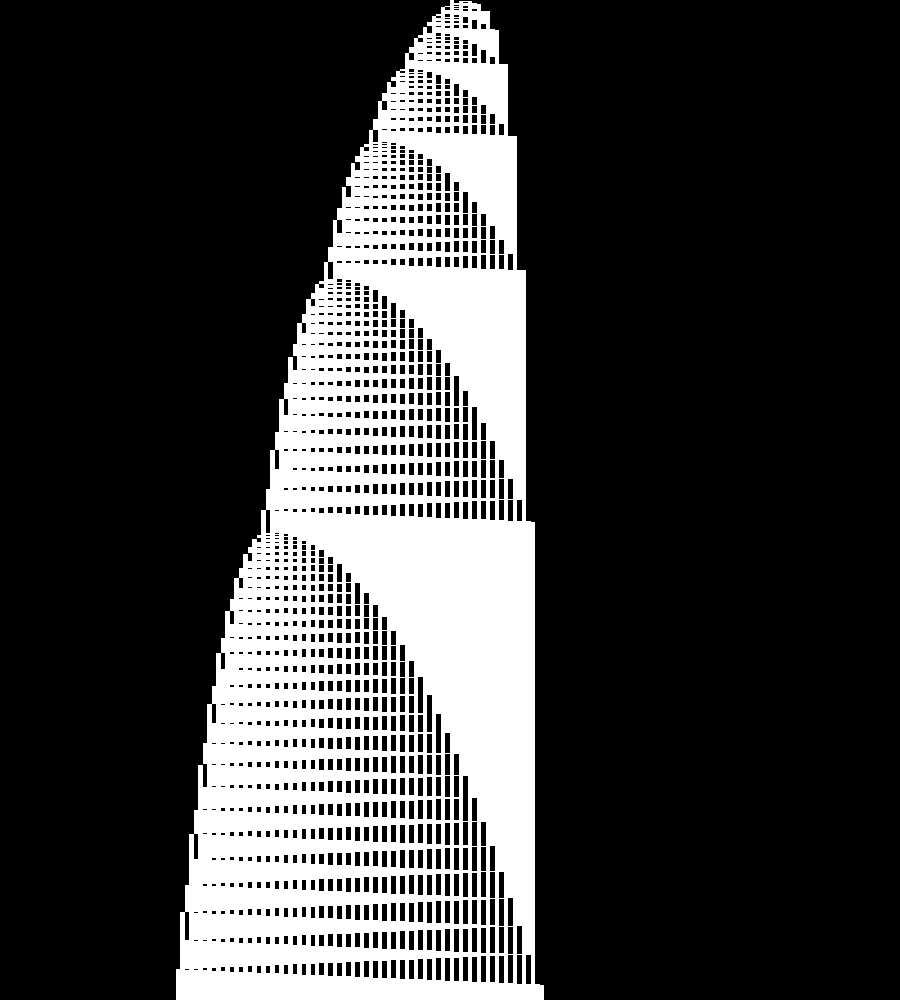

In [90]:
img = tm_trace_to_image(m, origin=0.5, width=200, height=5309).resize((900,1000), Image.NEAREST)
img

### 6987 steps

In [91]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, R, D,
		0, R, C, 1, R, C,
		1, L, A, 0, L, A,
		1, L, C, A, L, E,
		0, 0, 0, 0, L, D]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 6987 steps.")

s    0    1
---  ---  ---
A    1RB  1RD
B    0RC  1RC
C    1LA  0LA
D    1LC  1LE
E    ???  0LD
Halts after 6987 steps.


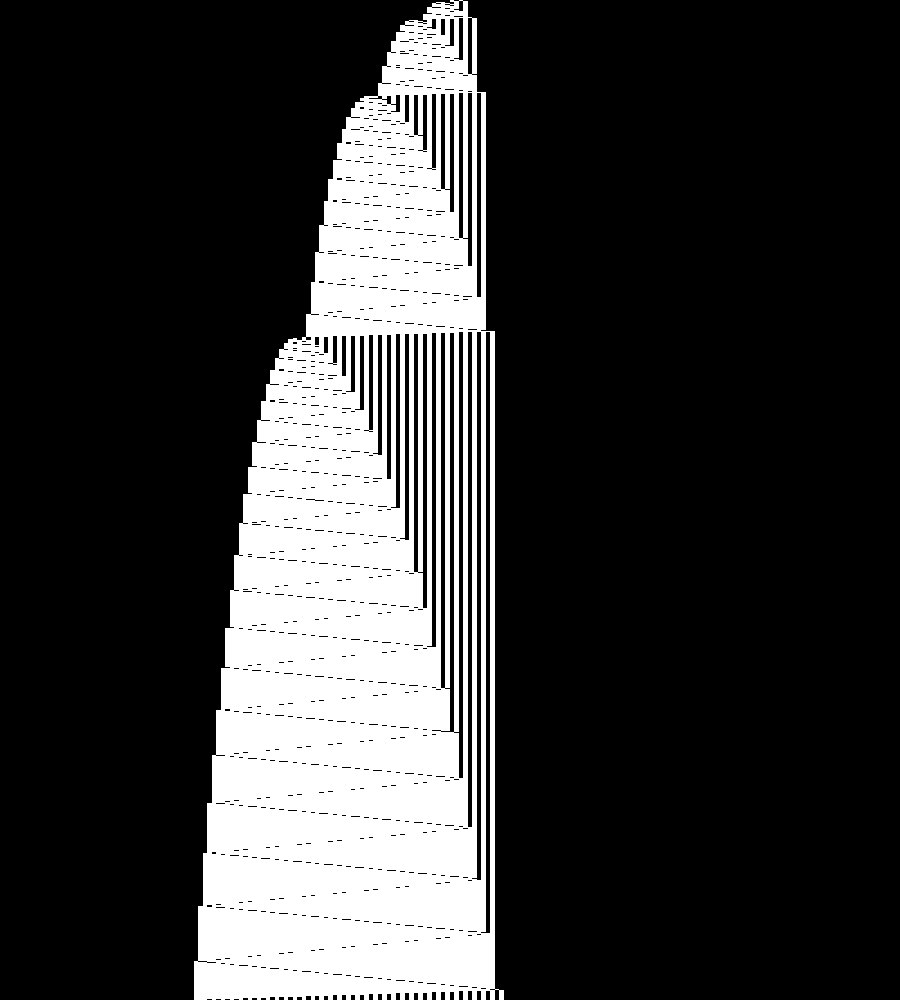

In [93]:
img = tm_trace_to_image(m, origin=0.5, width=200, height=6987).resize((900,1000), Image.NEAREST)
img

### 22335 steps

In [105]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, D,
		0, L, B, 1, R, C,
		1, L, D, 0, L, E,
		1, R, E, 1, L, C,
		0, 0, 0, 0, R, A]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 22335 steps.")

s    0    1
---  ---  ---
A    1RB  1LD
B    0LB  1RC
C    1LD  0LE
D    1RE  1LC
E    ???  0RA
Halts after 22335 steps.


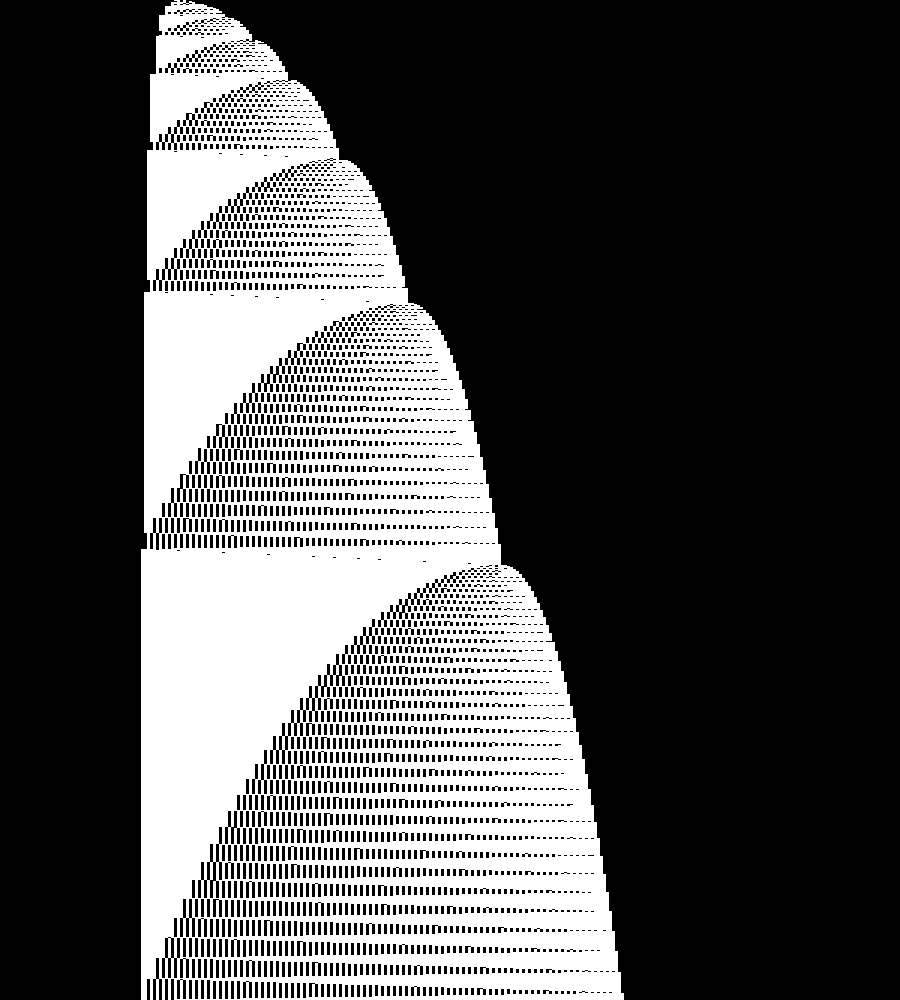

In [106]:
img = tm_trace_to_image(m, origin=0.2, width=300, height=22335).resize((900,1000), Image.NEAREST)
img

### 2133492 steps

In [96]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, C,
		0, L, A, 0, L, D,
		1, L, A, 0, 0, 0,
		1, L, B, 1, R, E,
		0, R, D, 0, R, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 2133492 steps.")

s    0    1
---  ---  ---
A    1RB  1LC
B    0LA  0LD
C    1LA  ???
D    1LB  1RE
E    0RD  0RB
Halts after 2133492 steps.


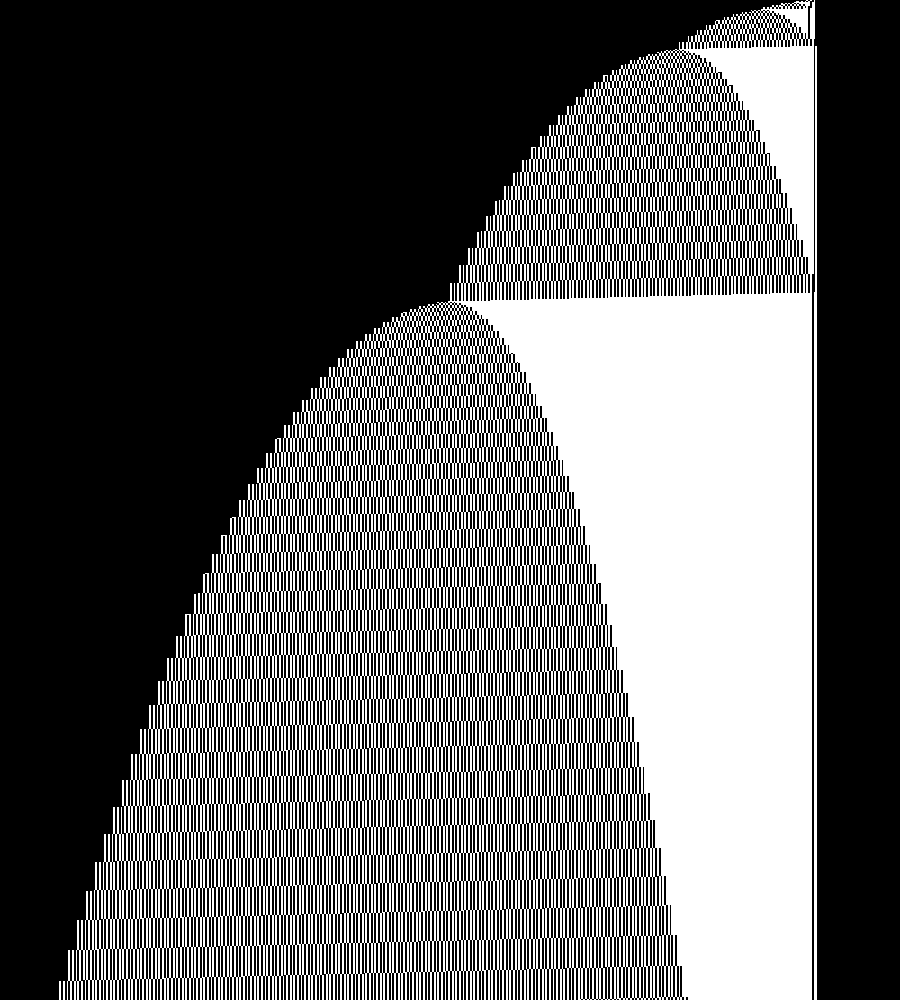

In [101]:
img = tm_trace_to_image(m, origin=0.9, width=500, height=22335).resize((900,1000), Image.NEAREST)
img

## "Chaotic" machine

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [19]:
R, L = 0, 1
chaotic_machine_rep = [1, L, 2, 1, R, 2,
		1, R, 3, 0, L, 5,
		0, R, 4, 0, L, 1,
		1, L, 1, 0, R, 4,
		1, L, 0, 0, L, 3]
chaotic_machine = repr_to_bytes(chaotic_machine_rep)
pptm(chaotic_machine)

s    0    1
---  ---  ---
A    1LB  1RB
B    1RC  0LE
C    0RD  0LA
D    1LA  0RD
E    ???  0LC


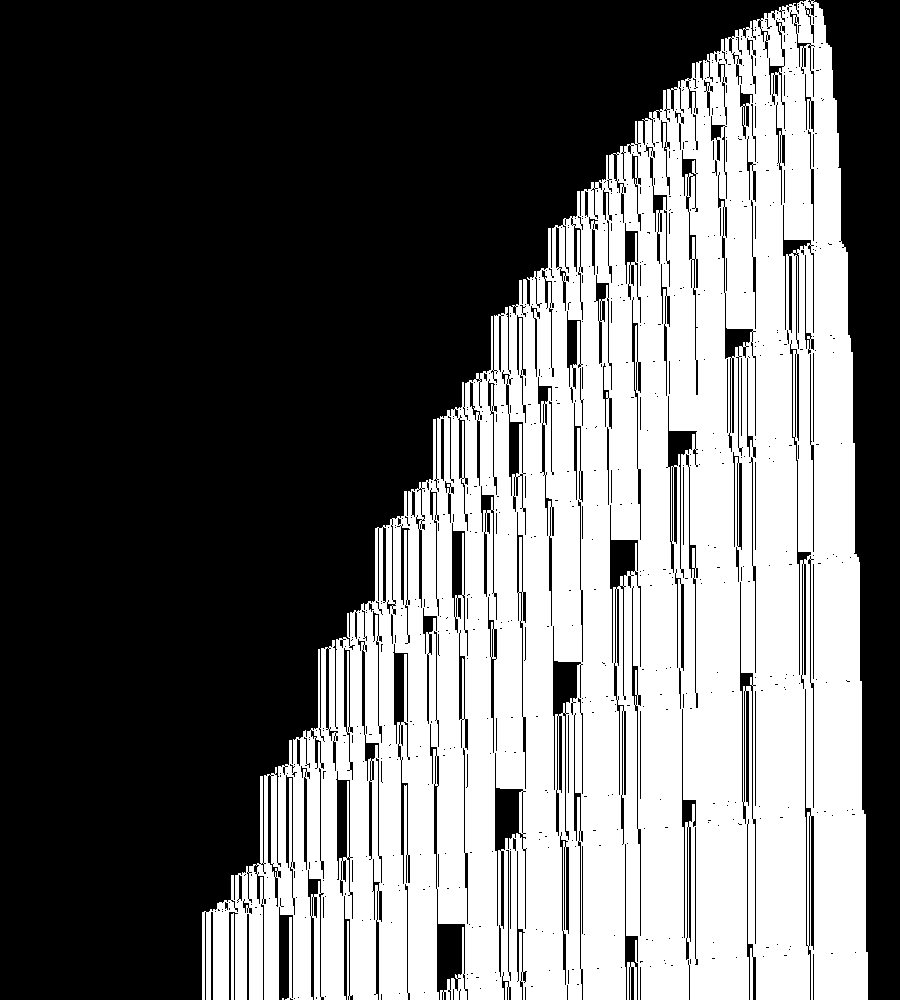

In [20]:
img = tm_trace_to_image(chaotic_machine, origin=0.9, width=1000, height=100000, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## "Complex counter"

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [21]:
R, L = 0, 1
complex_counter_rep = [1, L, 2, 1, R, 1,
		0, R, 1, 0, L, 3,
		0, R, 3, 1, L, 4,
		1, L, 5, 0, R, 1,
		0, L, 2, 1, L, 0]
complex_counter = repr_to_bytes(complex_counter_rep)
pptm(complex_counter)

s    0    1
---  ---  ---
A    1LB  1RA
B    0RA  0LC
C    0RC  1LD
D    1LE  0RA
E    0LB  ???


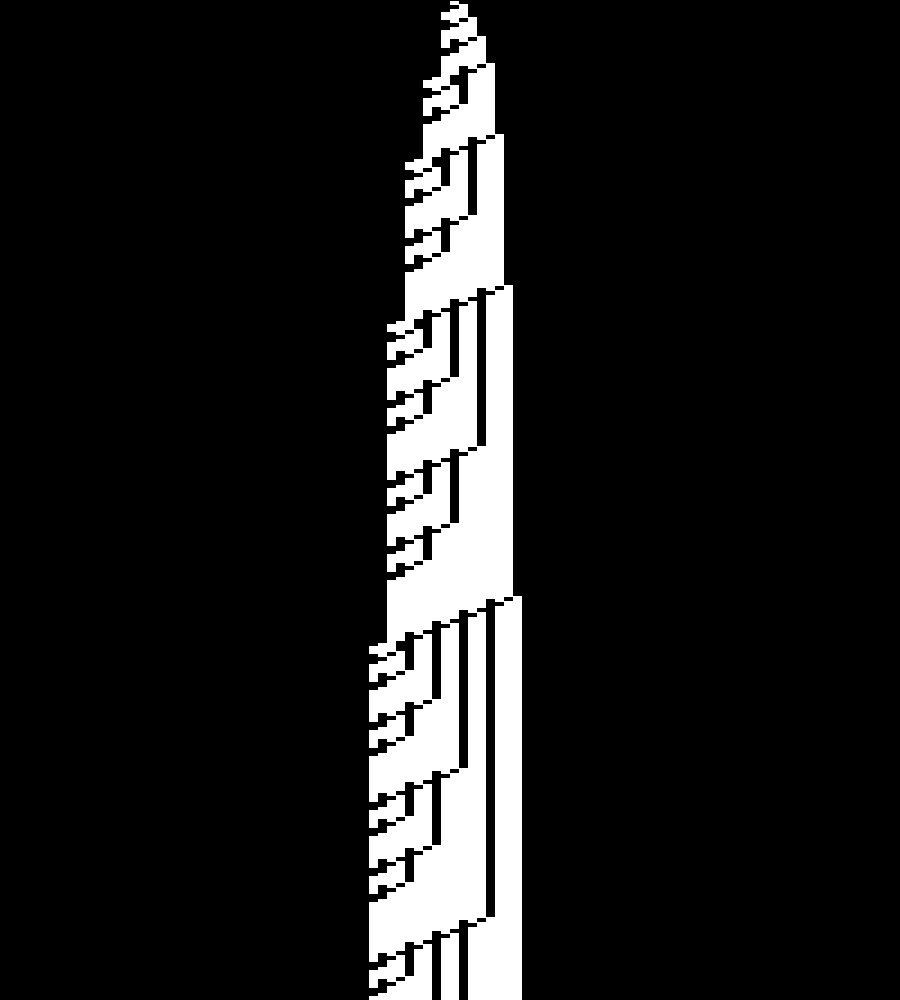

In [22]:
img = tm_trace_to_image(complex_counter, origin=0.5, width=100, height=1000, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## Random machine

In [23]:
n_history = []

s    0    1
---  ---  ---
A    1RB  ???
B    1LC  0LB
C    1RD  1LB
D    0LB  0RE
E    1RC  0RB
11727962


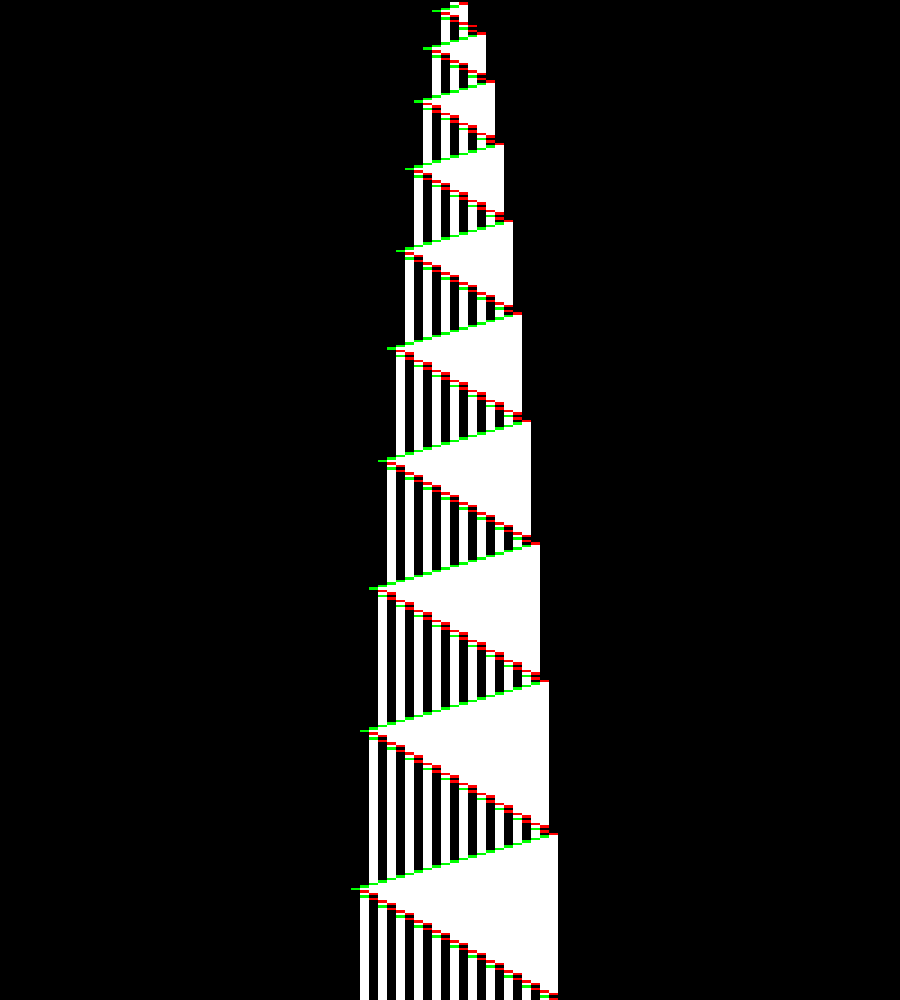

In [50]:
n = random.randint(0,undecided_total-1)
n_history.append(n)

print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

# Zoology

## Cyclers

13551916


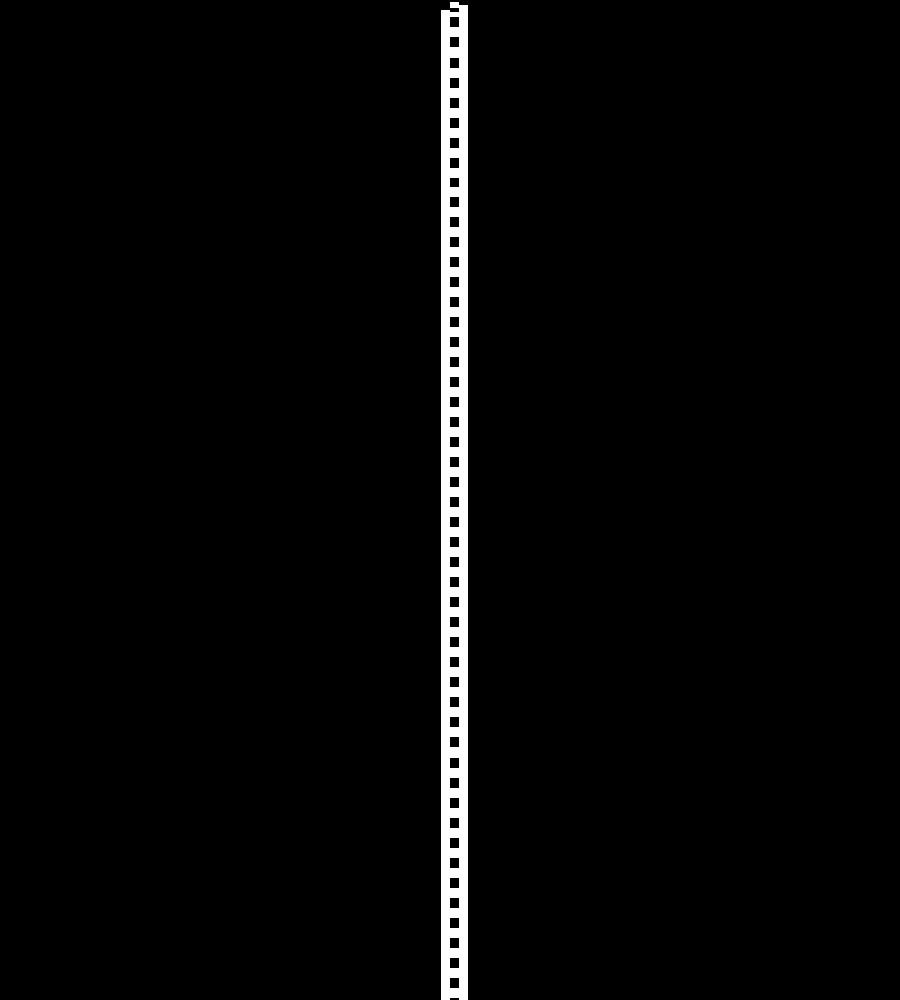

In [442]:
n_list = [5164458,13551916,4888230]
n = random.choice(n_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## Stairs / Translated Cyclers

In [1071]:
pptm(get_machine_i(DB_PATH,52297460))

s    0    1
---  ---  ---
A    1RB  0RE
B    1RC  1RB
C    1LD  1LE
D    ???  0LB
E    0LB  1RA


33613795


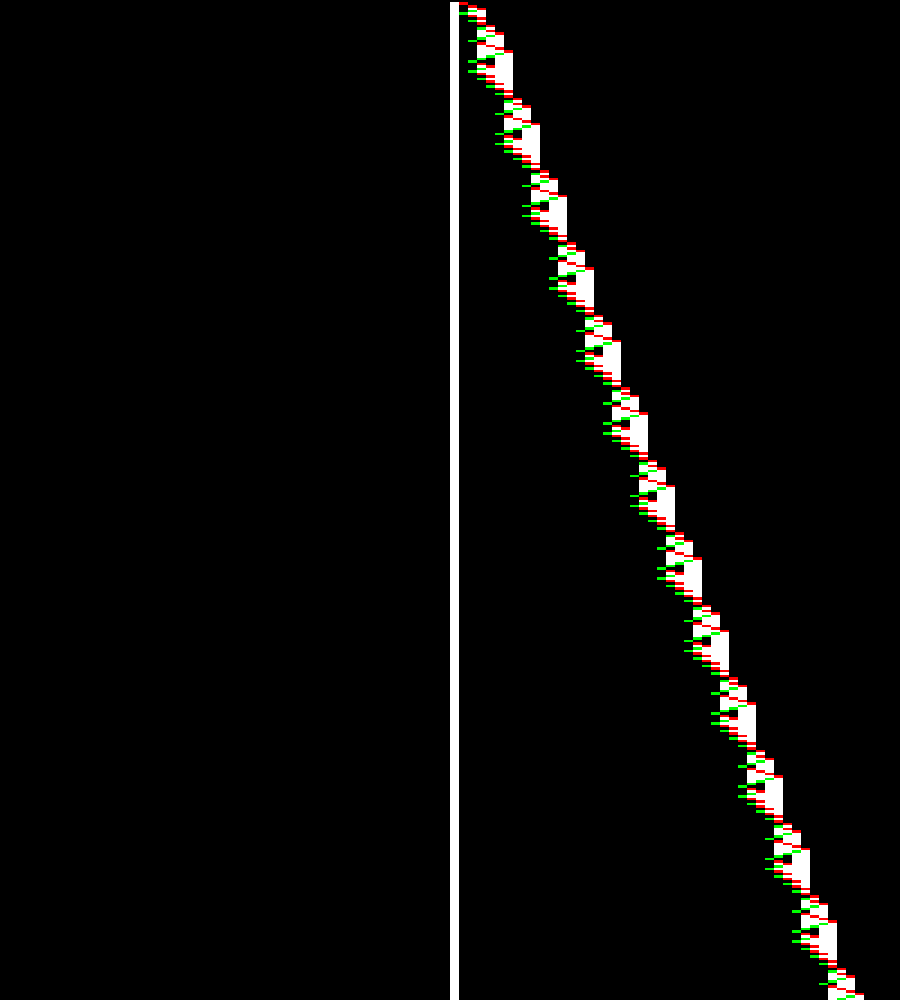

In [1079]:
n_list = [78619823,52297460,37549150,37799885,33613795,65712202,73643021,73823887,87711505]
n = random.choice(n_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Wedding Cakes / Babylon Towers

8852035


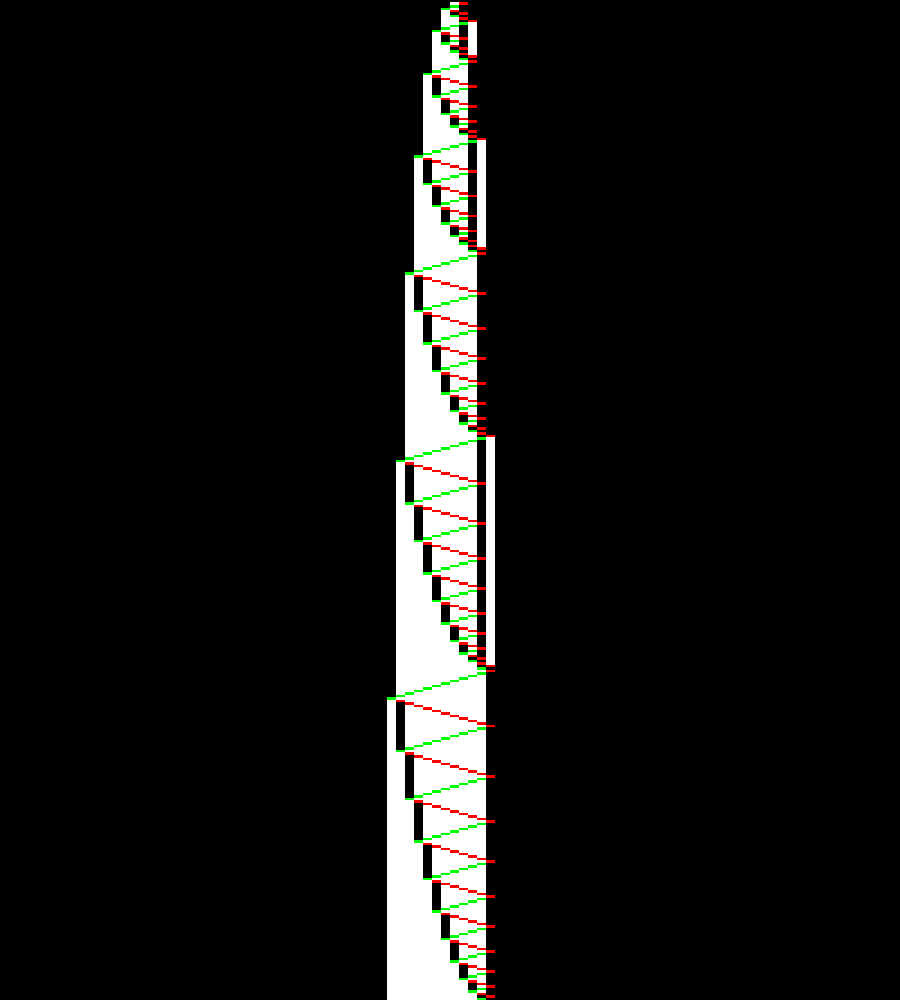

In [1344]:
n_list = [7888061,5351680,7199290,7177946,12930718,16322780,41540524,8852035,14203996,294146,13128061,12023842,3666258,56021279]
n = random.choice(n_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Binary Counters

7695095


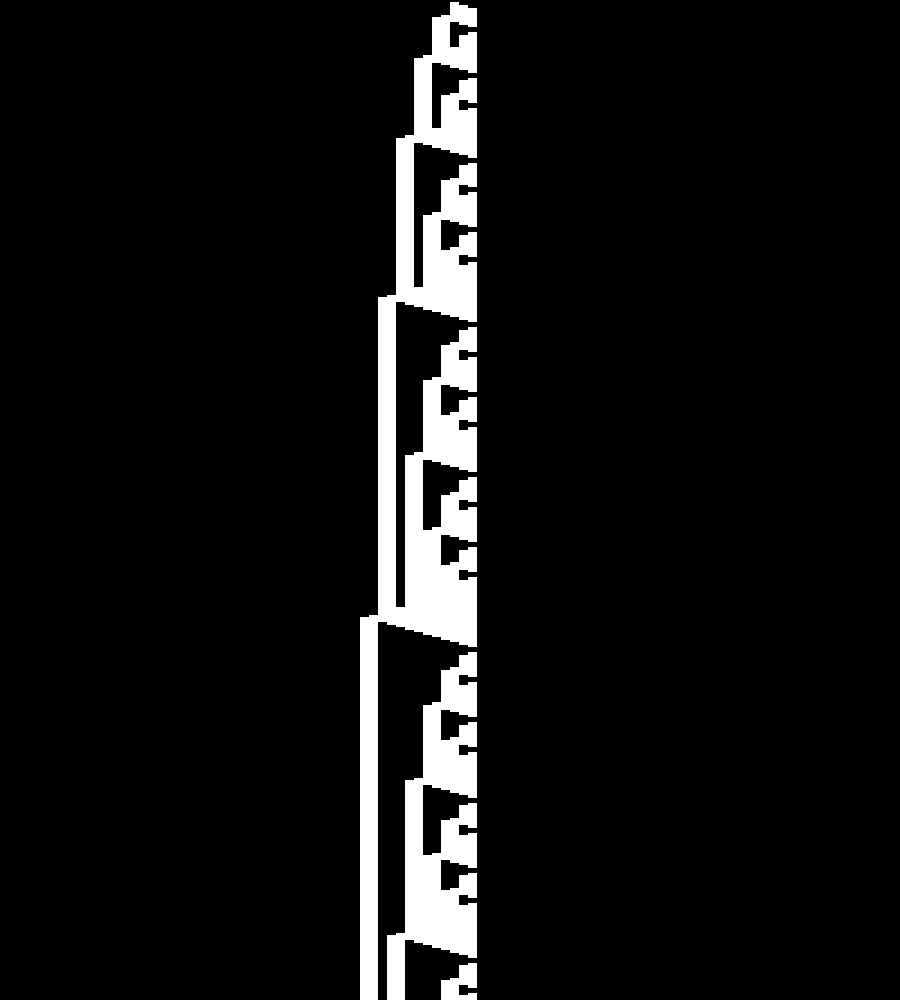

In [1317]:
n_list = [11184383,7931184, 7695095, 8594060]
n = random.choice(n_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## Not classed yet

3798341


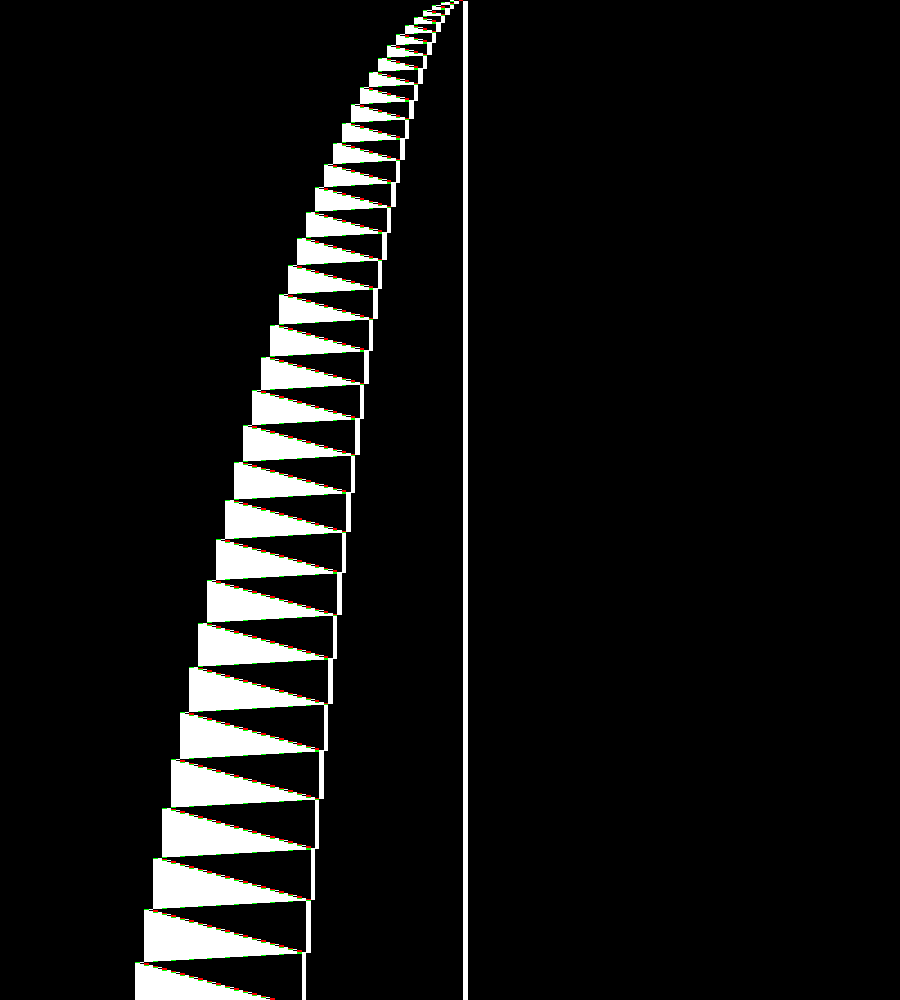

In [1386]:
n_list = [3329304,2293781,6830664,1323862,83975114, 82720961, 3001247, 3798341]
n = random.choice(n_list)
n = 3798341
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=200, height=4000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img